#Dataset Preprocessing






In [ ]:
# Clone the official HateXplain repository from GitHub
!git clone https://github.com/hate-alert/HateXplain.git

# Check that the folder is downloaded
!ls


Cloning into 'HateXplain'...
remote: Enumerating objects: 414, done.
remote: Counting objects: 100% (188/188), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 414 (delta 159), reused 142 (delta 142), pack-reused 226 (from 1)
Receiving objects: 100% (414/414), 6.75 MiB | 10.14 MiB/s, done.
Resolving deltas: 100% (235/235), done.
HateXplain  sample_data


In [ ]:
# Change current directory to the HateXplain folder
%cd HateXplain

# List files inside this repo
!ls

# Check the Data folder (where the JSON files are)
!ls Data


/content/HateXplain
best_model_json			     Models
best_runs.sh			     Parameters_description.md
Bias_Calculation_NB.ipynb	     parameters_selection.py
convert_to_word2vec.py		     Preprocess
Data				     README.md
eraserbenchmark			     requirements.txt
Example_HateExplain.ipynb	     TensorDataset
Explainability_Calculation_NB.ipynb  testing_for_bias.py
Figures				     testing_with_lime.py
LICENSE				     testing_with_rational.py
manual_training_inference.py	     test_parallel.sh
classes.npy  classes_two.npy  dataset.json  post_id_divisions.json  README.md


In [ ]:
# Cell 1: Install libraries and split the data
!pip install -q --upgrade transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 60.2 MB/s eta 0:00:00


In [ ]:
import json
import pandas as pd
import random
import ast
from collections import Counter
from datasets import Dataset
from transformers import AutoTokenizer
import os
import numpy as np
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch
import torch.nn as nn
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import time
from scipy.special import expit
from google.colab import userdata
import google.generativeai as genai




In [ ]:
# Load the main dataset file (or you can use train.json / val.json / test.json)
with open("Data/dataset.json", "r") as f:
    data = json.load(f)

# How many posts?
len(data)



20148

##Building the main DataFrame from the raw HateXplain JSON

In this cell, we convert the raw JSON structure into a clean pandas DataFrame.
We join the tokens into full text, collect all annotator labels and targets, and pick a simple majority label for each post.
This gives us one organized table that we can use for further analysis and model training.

In [ ]:

rows = []
for pid, info in data.items():
    # post text = join tokens
    text = " ".join(info["post_tokens"])

    # collect annotator labels
    labels = [ann["label"] for ann in info["annotators"]]
    targets = [ann["target"] for ann in info["annotators"]]

    # majority label (very simple strategy)
    main_label = max(set(labels), key=labels.count)

    rows.append({
        "post_id": pid,
        "text": text,
        "labels_all": labels,
        "targets_all": targets,
        "label_main": main_label,
    })

df = pd.DataFrame(rows)
df.to_csv("hatexplain_clean.csv", index=False)

df.head(20)


,post_id,text,labels_all,targets_all,label_main
0,1179055004553900032_twitter,i dont think im getting my baby them white 9 h...,"[normal, normal, normal]","[[None], [None], [None]]",normal
1,1179063826874032128_twitter,we cannot continue calling ourselves feminists...,"[normal, normal, normal]","[[None], [None], [None]]",normal
2,1178793830532956161_twitter,nawt yall niggers ignoring me,"[normal, normal, hatespeech]","[[African], [None], [African]]",normal
3,1179088797964763136_twitter,<user> i am bit confused coz chinese ppl can n...,"[hatespeech, offensive, hatespeech]","[[Asian], [Asian], [Asian]]",hatespeech
4,1179085312976445440_twitter,this bitch in whataburger eating a burger with...,"[hatespeech, hatespeech, offensive]","[[Caucasian, Women], [Women, Caucasian], [Wome...",hatespeech
5,13851720_gab,laura loomer raped me while screaming at me in...,"[hatespeech, hatespeech, hatespeech]","[[Jewish], [Jewish], [Jewish]]",hatespeech
6,24198545_gab,and this is why i end up with nigger trainee d...,"[hatespeech, hatespeech, offensive]","[[African], [African], [African]]",hatespeech
7,14567516_gab,nogs jews and dykes how enriching,"[offensive, hatespeech, offensive]","[[African, Jewish, Homosexual], [African, Jewi...",offensive
8,19679648_gab,guilty until proven innocent unless you are a ...,"[hatespeech, hatespeech, normal]","[[African, Jewish], [African, Jewish], [None]]",hatespeech
9,15858421_gab,tired i can not support abortion from a moral ...,"[hatespeech, hatespeech, normal]","[[African], [African], [None]]",hatespeech


##Dataset Consistency Checks: Making sure the JSON → table conversion is correct and matches the original data

Check total number of posts

In [ ]:
# Number of posts in raw JSON
print("len(data):", len(data))

# Number of rows in our DataFrame
print("df.shape[0]:", df.shape[0])


len(data): 20148
df.shape[0]: 20148


Verify text reconstruction from post_tokens

In [ ]:

def check_text_match(n=5):
    pids = random.sample(list(data.keys()), n)
    for pid in pids:
        info = data[pid]
        text_from_json = " ".join(info["post_tokens"])
        text_from_df = df.loc[df["post_id"] == pid, "text"].iloc[0]
        print("ID:", pid)
        print("  JSON:", text_from_json)
        print("   DF :", text_from_df)
        print("MATCH:", text_from_json == text_from_df)
        print("-" * 50)

check_text_match(5)


ID: 12941150_gab
  JSON: looks suspiciously like a white burkha for white women white women need to start wearing these asap
   DF : looks suspiciously like a white burkha for white women white women need to start wearing these asap
MATCH: True
--------------------------------------------------
ID: 14018754_gab
  JSON: yes it does at our offices we do not do business with muslim cockroaches
   DF : yes it does at our offices we do not do business with muslim cockroaches
MATCH: True
--------------------------------------------------
ID: 1126164185749053440_twitter
  JSON: <user> communal attack by their own didi agreed didi need to be thrown behind bar islamic jihadi
   DF : <user> communal attack by their own didi agreed didi need to be thrown behind bar islamic jihadi
MATCH: True
--------------------------------------------------
ID: 1179093793330651136_twitter
  JSON: <user> lol fuck you too
   DF : <user> lol fuck you too
MATCH: True
-------------------------------------------------

Validate majority label calculation

In [ ]:
def majority_label(labels):
    return max(set(labels), key=labels.count)

mismatches = 0

for pid, info in data.items():
    labels = [ann["label"] for ann in info["annotators"]]
    true_main = majority_label(labels)
    df_main = df.loc[df["post_id"] == pid, "label_main"].iloc[0]
    if true_main != df_main:
        mismatches += 1
        print("Mismatch for:", pid, "| JSON:", true_main, "| DF:", df_main)

print("Total mismatches:", mismatches)


Total mismatches: 0


Verify target lists for each post

In [ ]:
mismatches_targets = 0

for pid, info in data.items():
    targets_json = [ann["target"] for ann in info["annotators"]]
    targets_df = df.loc[df["post_id"] == pid, "targets_all"].iloc[0]


    if isinstance(targets_df, str):
        targets_df = ast.literal_eval(targets_df)

    if targets_json != targets_df:
        mismatches_targets += 1
        print("Mismatch targets for:", pid)
        print(" JSON:", targets_json)
        print(" DF  :", targets_df)
        print("-" * 40)

print("Total target mismatches:", mismatches_targets)


Total target mismatches: 0


##Dataset overview

###This cell helps us see the basic structure of the dataset, including the number of rows, columns, and data types.

In [ ]:

# Basic shape: number of rows and columns
print("Shape:", df.shape)

# Column names
print("\nColumns:", df.columns.tolist())

# Info about dtypes and non-null counts
df.info()

# See first 5 rows
df.head()



Shape: (20148, 5)

Columns: ['post_id', 'text', 'labels_all', 'targets_all', 'label_main']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20148 entries, 0 to 20147
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   post_id      20148 non-null  object
 1   text         20148 non-null  object
 2   labels_all   20148 non-null  object
 3   targets_all  20148 non-null  object
 4   label_main   20148 non-null  object
dtypes: object(5)
memory usage: 787.2+ KB


,post_id,text,labels_all,targets_all,label_main
0,1179055004553900032_twitter,i dont think im getting my baby them white 9 h...,"[normal, normal, normal]","[[None], [None], [None]]",normal
1,1179063826874032128_twitter,we cannot continue calling ourselves feminists...,"[normal, normal, normal]","[[None], [None], [None]]",normal
2,1178793830532956161_twitter,nawt yall niggers ignoring me,"[normal, normal, hatespeech]","[[African], [None], [African]]",normal
3,1179088797964763136_twitter,<user> i am bit confused coz chinese ppl can n...,"[hatespeech, offensive, hatespeech]","[[Asian], [Asian], [Asian]]",hatespeech
4,1179085312976445440_twitter,this bitch in whataburger eating a burger with...,"[hatespeech, hatespeech, offensive]","[[Caucasian, Women], [Women, Caucasian], [Wome...",hatespeech


In [ ]:
# Unique labels in label_main
print("Unique main labels:", df["label_main"].unique())

# Count of each label
print("\nLabel counts:")
print(df["label_main"].value_counts())

# Relative frequency (percentage)
print("\nLabel distribution (%):")
print(df["label_main"].value_counts(normalize=True) * 100)


Unique main labels: ['normal' 'hatespeech' 'offensive']

Label counts:
label_main
normal        8733
hatespeech    5935
offensive     5480
Name: count, dtype: int64

Label distribution (%):
label_main
normal        43.344253
hatespeech    29.457018
offensive     27.198729
Name: proportion, dtype: float64


### Main label distribution

Here we check how many samples belong to each main label: hatespeech, offensive, normal.This gives us a quick idea of how balanced or imbalanced the dataset is.

In [ ]:
# Unique labels in label_main
print("Unique main labels:", df["label_main"].unique())

# Count of each label
print("\nLabel counts:")
print(df["label_main"].value_counts())

# Relative frequency (percentage)
print("\nLabel distribution (%):")
print(df["label_main"].value_counts(normalize=True) * 100)


Unique main labels: ['normal' 'hatespeech' 'offensive']

Label counts:
label_main
normal        7814
offensive     6399
hatespeech    5935
Name: count, dtype: int64

Label distribution (%):
label_main
normal        38.783006
offensive     31.759976
hatespeech    29.457018
Name: proportion, dtype: float64


### Annotator label analysis

This shows all labels assigned by different annotators and how often each one appears.It helps us understand disagreement between annotators.

In [ ]:
# How many distinct annotation label sets exist?
df["labels_all"].head()

# Flatten all annotator labels to see global distribution
from collections import Counter

all_ann_labels = []
for lab_list in df["labels_all"]:
    all_ann_labels.extend(lab_list)   # lab_list is like ['normal','normal','hatespeech']

print("All annotator label counts:")
Counter(all_ann_labels)


All annotator label counts:


Counter({'normal': 24449, 'hatespeech': 18070, 'offensive': 17925})

### Target category counts

This cell tells us how many times each target appears (African, Jewish, Women, etc.).It’s useful for knowing which target groups have enough data.

In [ ]:
all_targets = []

for target_lists in df["targets_all"]:
    # target_lists: like [['None'], ['African'], ['None']]
    for t_list in target_lists:
        for t in t_list:
            if t != "None":           # ignore 'None' targets
                all_targets.append(t)

print("Number of non-None target mentions:", len(all_targets))
print("\nTarget counts:")
Counter(all_targets)


Number of non-None target mentions: 53161

Target counts:


Counter({'African': 10015,
         'Asian': 1350,
         'Caucasian': 2359,
         'Women': 6126,
         'Jewish': 5961,
         'Homosexual': 5617,
         'Islam': 6686,
         'Other': 4708,
         'Hispanic': 1299,
         'Refugee': 3100,
         'Men': 1758,
         'Arab': 2907,
         'Disability': 221,
         'Minority': 188,
         'Nonreligious': 87,
         'Indigenous': 83,
         'Indian': 81,
         'Economic': 90,
         'Christian': 270,
         'Heterosexual': 141,
         'Bisexual': 8,
         'Hindu': 89,
         'Buddhism': 12,
         'Asexual': 5})

### Samples with real targets

We filter and display posts that actually have a meaningful target (not “None”).This shows how many valid target examples we have

In [ ]:
def has_real_target(target_lists):
    for t_list in target_lists:
        for t in t_list:
            if t != "None":
                return True
    return False

df_with_target = df[df["targets_all"].apply(has_real_target)]

print("Rows with at least one real target:", df_with_target.shape[0])

df_with_target.head(5)[["post_id", "text", "targets_all", "label_main"]]


### Hatespeech + target combination analysis


Here we check how many hatespeech posts target each group.
This helps us understand whether we have enough data for each class in the second task (target classification).

In [ ]:
# Helper to get a flat list of targets for each row
def extract_targets_flat(target_lists):
    out = []
    for t_list in target_lists:
        for t in t_list:
            if t != "None":
                out.append(t)
    return out

df["targets_flat"] = df["targets_all"].apply(extract_targets_flat)

# Example: rows with hatespeech and at least one target
df_hate = df[(df["label_main"] == "hatespeech") & (df["targets_flat"].str.len() > 0)]
print("Hatespeech rows with real targets:", df_hate.shape[0])

# Count targets only among hatespeech rows
from collections import Counter
target_counts = Counter([t for ts in df_hate["targets_flat"] for t in ts])

print("Number of unique target categories:", len(target_counts))

# Count targets only among hatespeech rows
from collections import Counter
target_counts = Counter([t for ts in df_hate["targets_flat"] for t in ts])
len(target_counts)
target_counts.most_common(24)


Hatespeech rows with real targets: 5925
Number of unique target categories: 24


[('African', 6578),
 ('Jewish', 4024),
 ('Islam', 3455),
 ('Homosexual', 2046),
 ('Arab', 1732),
 ('Women', 1541),
 ('Other', 1141),
 ('Hispanic', 795),
 ('Refugee', 711),
 ('Caucasian', 561),
 ('Asian', 539),
 ('Men', 432),
 ('Minority', 152),
 ('Christian', 84),
 ('Disability', 80),
 ('Nonreligious', 65),
 ('Heterosexual', 58),
 ('Indian', 47),
 ('Indigenous', 40),
 ('Hindu', 23),
 ('Economic', 18),
 ('Asexual', 5),
 ('Bisexual', 2),
 ('Buddhism', 1)]

##Install libraries + create train/val/test splits

In [ ]:
# Load the official split file from HateXplain
path_splits = "/content/HateXplain/Data/post_id_divisions.json"
with open(path_splits, "r") as f:
    splits = json.load(f)

print("Available splits:", splits.keys())

# Get post_ids for each split
train_ids = splits["train"]
val_ids   = splits["val"]
test_ids  = splits["test"]

# Use post_id to filter rows from the full DataFrame `df`
df_train = df[df["post_id"].isin(train_ids)].reset_index(drop=True)
df_val   = df[df["post_id"].isin(val_ids)].reset_index(drop=True)
df_test  = df[df["post_id"].isin(test_ids)].reset_index(drop=True)

print("Train size:", df_train.shape)
print("Val size  :", df_val.shape)
print("Test size :", df_test.shape)

# Map string labels to integers
label2id = {
    "hatespeech": 0,
    "offensive": 1,
    "normal": 2,
}
id2label = {v: k for k, v in label2id.items()}

# Add numeric label column to each split
df_train["label_id"] = df_train["label_main"].map(label2id)
df_val["label_id"]   = df_val["label_main"].map(label2id)
df_test["label_id"]  = df_test["label_main"].map(label2id)

df_train[["label_main", "label_id"]].head()


Available splits: dict_keys(['test', 'train', 'val'])
Train size: (15383, 5)
Val size  : (1922, 5)
Test size : (1924, 5)


,label_main,label_id
0,normal,2
1,normal,2
2,hatespeech,0
3,hatespeech,0
4,offensive,1


# Task 1 (Train Models- Base)

##Baseline: BERT-base

###Build HuggingFace Datasets and tokenize(Bert)

In [ ]:
# Keep only the columns we need: text + numeric label
train_ds = Dataset.from_pandas(df_train[["text", "label_id"]])
val_ds   = Dataset.from_pandas(df_val[["text", "label_id"]])
test_ds  = Dataset.from_pandas(df_test[["text", "label_id"]])

# Load BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_batch(batch):
    """
    Tokenize a batch of texts for BERT.
    We also copy label_id into 'labels' key for training.
    """
    encodings = tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=128,
    )
    encodings["labels"] = batch["label_id"]
    return encodings

# Apply tokenization to all splits
train_ds_tok = train_ds.map(tokenize_batch, batched=True)
val_ds_tok   = val_ds.map(tokenize_batch, batched=True)
test_ds_tok  = test_ds.map(tokenize_batch, batched=True)

# Set dataset format for PyTorch Trainer
cols = ["input_ids", "attention_mask", "labels"]
train_ds_tok.set_format(type="torch", columns=cols)
val_ds_tok.set_format(type="torch", columns=cols)
test_ds_tok.set_format(type="torch", columns=cols)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/15383 [00:00<?, ? examples/s]

Map:   0%|          | 0/1922 [00:00<?, ? examples/s]

Map:   0%|          | 0/1924 [00:00<?, ? examples/s]

###Load model and set up Trainer(Bert)

In [ ]:
# Disable wandb so it does not ask for API key
os.environ["WANDB_DISABLED"] = "true"

# Load BERT-base model with 3 output labels
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=3,
    id2label=id2label,
    label2id=label2id,
)

# Metric function: accuracy and macro-F1
def compute_metrics(eval_pred):
    """
    Compute accuracy and macro-F1 on eval dataset.
    """
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc = accuracy_score(labels, preds)
    f1_macro = f1_score(labels, preds, average="macro")

    return {
        "accuracy": acc,
        "f1_macro": f1_macro,
    }

# Basic training arguments for a small baseline
training_args = TrainingArguments(
    output_dir="./bert_baseline",   # where to save model/checkpoints
    num_train_epochs=4,             # small number for baseline
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    logging_steps=100,              # print every 100 training steps

)

# Create Trainer object
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds_tok,   # training data
    eval_dataset=val_ds_tok,      # will use this when we call trainer.evaluate(...)
    compute_metrics=compute_metrics,
)

# Train the BERT baseline model
trainer.train()


###Final evaluation on TEST set(bert)

In [ ]:
# Cell 4: Evaluate on validation and test sets

print("=== Validation metrics ===")
val_metrics = trainer.evaluate(eval_dataset=val_ds_tok)
print(val_metrics)

print("\n=== Test metrics ===")
test_metrics = trainer.evaluate(eval_dataset=test_ds_tok)
print(test_metrics)

## Baseline: Roberta-base

### Build HuggingFace Datasets and tokenize(Roberta)

In [ ]:
# Keep only the columns we need: text + numeric label
train_ds = Dataset.from_pandas(df_train[["text", "label_id"]])
val_ds   = Dataset.from_pandas(df_val[["text", "label_id"]])
test_ds  = Dataset.from_pandas(df_test[["text", "label_id"]])

# Load RoBERTa tokenizer instead of BERT
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

def tokenize_batch(batch):
    """
    Tokenize a batch of texts for RoBERTa.
    We also copy label_id into 'labels' key for training.
    """
    encodings = tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=128,
    )
    encodings["labels"] = batch["label_id"]
    return encodings

# Apply tokenization to all splits
train_ds_tok = train_ds.map(tokenize_batch, batched=True)
val_ds_tok   = val_ds.map(tokenize_batch, batched=True)
test_ds_tok  = test_ds.map(tokenize_batch, batched=True)

# Set dataset format for PyTorch Trainer
cols = ["input_ids", "attention_mask", "labels"]
train_ds_tok.set_format(type="torch", columns=cols)
val_ds_tok.set_format(type="torch", columns=cols)
test_ds_tok.set_format(type="torch", columns=cols)


###Load model and set up Trainer(Roberta)

In [ ]:
# Disable wandb so it does not ask for API key
os.environ["WANDB_DISABLED"] = "true"

# Load RoBERTa-base model with 3 output labels
model = AutoModelForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=3,
    id2label=id2label,
    label2id=label2id,
)

# Metric function: accuracy and macro-F1
def compute_metrics(eval_pred):
    """
    Compute accuracy and macro-F1 on eval dataset.
    """
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc = accuracy_score(labels, preds)
    f1_macro = f1_score(labels, preds, average="macro")

    return {
        "accuracy": acc,
        "f1_macro": f1_macro,
    }

# Basic training arguments for a small baseline
training_args = TrainingArguments(
    output_dir="./roberta_baseline",   # changed folder name (optional)
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    logging_steps=100,
)

# Create Trainer object
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds_tok,
    eval_dataset=val_ds_tok,
    compute_metrics=compute_metrics,
)

# Train the RoBERTa baseline model
trainer.train()


###Final evaluation on TEST set(Roberta)

In [ ]:
# Cell 4: Evaluate on validation and test sets
print("=== Roberta Validation metrics ===")
val_metrics = trainer.evaluate(eval_dataset=val_ds_tok)
print(val_metrics)

print("\n=== Roberta Test metrics ===")
test_metrics = trainer.evaluate(eval_dataset=test_ds_tok)
print(test_metrics)



## Baseline: DeBERTa-v3-Base

### Build HuggingFace Datasets and tokenize(DeBERTa-v3)

In [ ]:
# We only keep the columns we need: text + numeric label
train_ds = Dataset.from_pandas(df_train[["text", "label_id"]])
val_ds   = Dataset.from_pandas(df_val[["text", "label_id"]])
test_ds  = Dataset.from_pandas(df_test[["text", "label_id"]])

# Load DeBERTa-v3 tokenizer
# "microsoft/deberta-v3-base" is a common DeBERTa-v3 checkpoint
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")

def tokenize_batch(batch):
    """
    Tokenize a batch of texts for DeBERTa-v3.
    Also copy label_id into 'labels' key for training.
    """
    encodings = tokenizer(
        batch["text"],
        padding="max_length",   # pad all to the same length
        truncation=True,        # cut long texts
        max_length=128,         # max tokens per example
    )
    # Add labels for the Trainer
    encodings["labels"] = batch["label_id"]
    return encodings

# Apply tokenization to all splits
train_ds_tok = train_ds.map(tokenize_batch, batched=True)
val_ds_tok   = val_ds.map(tokenize_batch, batched=True)
test_ds_tok  = test_ds.map(tokenize_batch, batched=True)

# Set dataset format for PyTorch Trainer
cols = ["input_ids", "attention_mask", "labels"]
train_ds_tok.set_format(type="torch", columns=cols)
val_ds_tok.set_format(type="torch", columns=cols)
test_ds_tok.set_format(type="torch", columns=cols)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/15383 [00:00<?, ? examples/s]

Map:   0%|          | 0/1922 [00:00<?, ? examples/s]

Map:   0%|          | 0/1924 [00:00<?, ? examples/s]

###Load model and set up Trainer(DeBERTa-v3)

In [ ]:
# Disable wandb so it does not ask for API key
os.environ["WANDB_DISABLED"] = "true"

# Load DeBERTa-v3 model with 3 output labels
model = AutoModelForSequenceClassification.from_pretrained(
    "microsoft/deberta-v3-base",  # change this if you want another DeBERTa-v3 size
    num_labels=3,                 # we have 3 classes: hatespeech/offensive/normal
    id2label=id2label,
    label2id=label2id,
)

def compute_metrics(eval_pred):
    """
    Compute accuracy and macro-F1 on eval dataset.
    """
    logits, labels = eval_pred
    # Take the index of the highest logit as prediction
    preds = np.argmax(logits, axis=-1)

    acc = accuracy_score(labels, preds)
    f1_macro = f1_score(labels, preds, average="macro")

    return {
        "accuracy": acc,
        "f1_macro": f1_macro,
    }

# Basic training arguments for a simple baseline
training_args = TrainingArguments(
    output_dir="./deberta_v3_baseline",  # where to save model/checkpoints
    num_train_epochs=4,                  # small number for baseline
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=3e-5,
    logging_steps=100,                   # print logs every 100 training steps
)

# Create Trainer object
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds_tok,   # training data
    # eval_dataset=val_ds_tok,      # validation data for evaluation
    compute_metrics=compute_metrics,
)

# Train the DeBERTa-v3 baseline model
trainer.train()


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss
100,1.047700
200,0.886200
300,0.838100
400,0.782600
500,0.781000
600,0.781800
700,0.734200
800,0.738800
900,0.750300
1000,0.693200


TrainOutput(global_step=3848, training_loss=0.5876242499837261, metrics={'train_runtime': 2653.6158, 'train_samples_per_second': 23.188, 'train_steps_per_second': 1.45, 'total_flos': 4047546291010560.0, 'train_loss': 0.5876242499837261, 'epoch': 4.0})

###Final evaluation on TEST set(DeBERTa-v3)

In [ ]:
# Cell 3: Evaluate DeBERTa-v3 on validation and test sets
print("=== DeBERTa-v3 Validation metrics ===")
val_metrics = trainer.evaluate(eval_dataset=val_ds_tok)
print(val_metrics)

print("\n=== DeBERTa-v3 Test metrics ===")
test_metrics = trainer.evaluate(eval_dataset=test_ds_tok)
print(test_metrics)


=== DeBERTa-v3 Validation metrics ===


NameError: name 'trainer' is not defined

## Baseline: BERTweet-Base

###Build HuggingFace Datasets and tokenize(Bertweet)

In [ ]:
# Keep only the columns we need: text + numeric label
train_ds = Dataset.from_pandas(df_train[["text", "label_id"]])
val_ds   = Dataset.from_pandas(df_val[["text", "label_id"]])
test_ds  = Dataset.from_pandas(df_test[["text", "label_id"]])

# 🔹 Load Bertweet tokenizer instead of BERT
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base")

def tokenize_batch(batch):
    """
    Tokenize a batch of texts for Bertweet.
    We also copy label_id into 'labels' key for training.
    """
    encodings = tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=128,
    )
    encodings["labels"] = batch["label_id"]
    return encodings

# Apply tokenization to all splits
train_ds_tok = train_ds.map(tokenize_batch, batched=True)
val_ds_tok   = val_ds.map(tokenize_batch, batched=True)
test_ds_tok  = test_ds.map(tokenize_batch, batched=True)

# Set dataset format for PyTorch Trainer
cols = ["input_ids", "attention_mask", "labels"]
train_ds_tok.set_format(type="torch", columns=cols)
val_ds_tok.set_format(type="torch", columns=cols)
test_ds_tok.set_format(type="torch", columns=cols)


emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


Map:   0%|          | 0/15383 [00:00<?, ? examples/s]

Map:   0%|          | 0/1922 [00:00<?, ? examples/s]

Map:   0%|          | 0/1924 [00:00<?, ? examples/s]

###Load model and set up Trainer(Bertweet)

In [ ]:
# 1) Compute class weights from training labels (0, 1, 2)
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.array([0, 1, 2]),            # we have 3 classes
    y=df_train["label_id"].values           # numeric labels in train set
)

print("Class weights (0, 1, 2):", class_weights)


# Disable wandb so it does not ask for API key
os.environ["WANDB_DISABLED"] = "true"


# Turn into a torch tensor
class_weights = torch.tensor(class_weights, dtype=torch.float)

# 2) Load BERTweet model for 3-class classification
model = AutoModelForSequenceClassification.from_pretrained(
    "vinai/bertweet-base",
    num_labels=3,        # hatespeech / offensive / normal
    id2label=id2label,   # e.g., {0: "normal", 1: "offensive", 2: "hatespeech"}
    label2id=label2id,   # e.g., {"normal": 0, "offensive": 1, "hatespeech": 2}
)

# 3) Metric function: accuracy and macro-F1
def compute_metrics(eval_pred):
    """
    Compute accuracy and macro-F1 on eval dataset.
    """
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc = accuracy_score(labels, preds)
    f1_macro = f1_score(labels, preds, average="macro")

    return {
        "accuracy": acc,
        "f1_macro": f1_macro,
    }

# 4) Custom Trainer that uses class weights in loss
class WeightedTrainer(Trainer):
    """
    Trainer that applies class weights in CrossEntropy loss.
    """
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs["labels"]
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # CrossEntropy with class weights
        loss_fn = nn.CrossEntropyLoss(weight=class_weights.to(logits.device))
        loss = loss_fn(logits, labels)

        return (loss, outputs) if return_outputs else loss

# 5) Basic TrainingArguments (compatible with older transformers)
training_args = TrainingArguments(
    output_dir="./bertweet_baseline_weighted",
    num_train_epochs=4,              # simple baseline
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=3e-5,
    # weight_decay=0.02,               # regularization
    logging_steps=100,
    # مهم: evaluation_strategy، save_strategy، report_to و... نذار
)

# 6) Create Trainer
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds_tok,
    eval_dataset=val_ds_tok,
    compute_metrics=compute_metrics,
)

# 7) Train model
trainer.train()



Class weights (0, 1, 2): [1.07996349 1.169632   0.82029542]


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss
100,0.979000
200,0.805600
300,0.810500
400,0.761700
500,0.760400
600,0.733600
700,0.727200
800,0.742700
900,0.746000
1000,0.660900


TrainOutput(global_step=3848, training_loss=0.5583492624040949, metrics={'train_runtime': 1709.8107, 'train_samples_per_second': 35.988, 'train_steps_per_second': 2.251, 'total_flos': 4047473704909824.0, 'train_loss': 0.5583492624040949, 'epoch': 4.0})

###Final evaluation on TEST set(Bertweet)

In [ ]:
# ================================================================
# Evaluate Bertweet for Task 1 (Normal / Offensive / Hatespeech)
# We compute:
# - Accuracy
# - Macro-F1
# - Recall for the "hatespeech" class
# - Confusion Matrix (optional)
# ================================================================

def evaluate_task1(trainer, ds, ds_name):
    """
    Simple evaluation function for Task 1.
    Computes Accuracy, Macro-F1, and Recall for the hatespeech class.
    """
    print(f"\n=== {ds_name} metrics ===")

    # ---- Get predictions from Trainer ----
    raw_pred = trainer.predict(ds)
    logits = raw_pred.predictions
    labels = raw_pred.label_ids

    # ---- Convert logits to predicted class numbers ----
    preds = np.argmax(logits, axis=-1)

    # ---- Compute metrics ----
    acc = accuracy_score(labels, preds)
    f1_macro = f1_score(labels, preds, average="macro")

    # Recall for class "hatespeech" → class index = 2
    recall_hate = recall_score(labels, preds, labels=[2], average="macro")

    print({
        "accuracy": acc,
        "macro_f1": f1_macro,
        "recall_hate": recall_hate
    })

    # ---- Optional: confusion matrix ----
    cm = confusion_matrix(labels, preds)
    print("\nConfusion Matrix:")
    print(cm)

    return acc, f1_macro, recall_hate


# =======================
# Run evaluation
# =======================

evaluate_task1(trainer, val_ds_tok, "Bertweet Validation")
evaluate_task1(trainer, test_ds_tok, "Bertweet Test")



=== Bertweet Validation metrics ===


{'accuracy': 0.6982310093652445, 'macro_f1': 0.6911178370310852, 'recall_hate': 0.70550576184379}

Confusion Matrix:
[[479  87  27]
 [108 312 128]
 [ 52 178 551]]

=== Bertweet Test metrics ===


{'accuracy': 0.696985446985447, 'macro_f1': 0.6855047585346155, 'recall_hate': 0.7186700767263428}

Confusion Matrix:
[[493  71  30]
 [120 286 142]
 [ 62 158 562]]


(0.696985446985447, 0.6855047585346155, 0.7186700767263428)

## compare all models on difference plots

In [ ]:
# ---- put your real numbers here if they are slightly different ----
results = {
    "Model": ["BERT-base", "RoBERTa-base", "DeBERTa-v3-base", "BERTweet-base"],
    "Val_Accuracy": [0.693, 0.701, 0.7118, 0.6982],
    "Val_MacroF1":  [0.6831, 0.6934, 0.7029, 0.6911],
    "Test_Accuracy": [0.6933, 0.6897, 0.7032, 0.6969],
    "Test_MacroF1":  [0.6827, 0.6766, 0.6925, 0.6855],
}

df_task1 = pd.DataFrame(results)
df_task1


,Model,Val_Accuracy,Val_MacroF1,Test_Accuracy,Test_MacroF1
0,BERT-base,0.6930,0.6831,0.6933,0.6827
1,RoBERTa-base,0.7010,0.6934,0.6897,0.6766
2,DeBERTa-v3-base,0.7118,0.7029,0.7032,0.6925
3,BERTweet-base,0.6982,0.6911,0.6969,0.6855


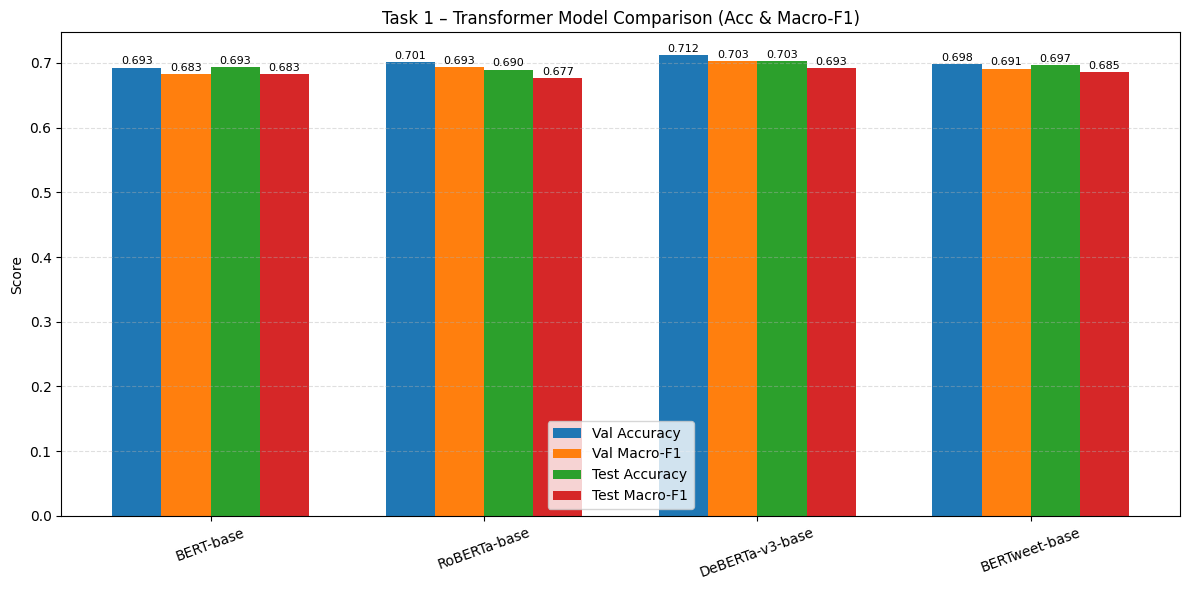

In [ ]:
# X positions
x = np.arange(len(df_task1["Model"]))
width = 0.18  # bar width

plt.figure(figsize=(12, 6))

# draw bars
b1 = plt.bar(x - 1.5*width, df_task1["Val_Accuracy"],  width, label="Val Accuracy")
b2 = plt.bar(x - 0.5*width, df_task1["Val_MacroF1"],   width, label="Val Macro-F1")
b3 = plt.bar(x + 0.5*width, df_task1["Test_Accuracy"], width, label="Test Accuracy")
b4 = plt.bar(x + 1.5*width, df_task1["Test_MacroF1"],  width, label="Test Macro-F1")

# add value labels on top of bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2,
            height + 0.002,
            f"{height:.3f}",
            ha="center",
            va="bottom",
            fontsize=8,
        )

add_labels(b1)
add_labels(b2)
add_labels(b3)
add_labels(b4)

plt.xticks(x, df_task1["Model"], rotation=20)
plt.ylabel("Score")
plt.title("Task 1 – Transformer Model Comparison (Acc & Macro-F1)")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


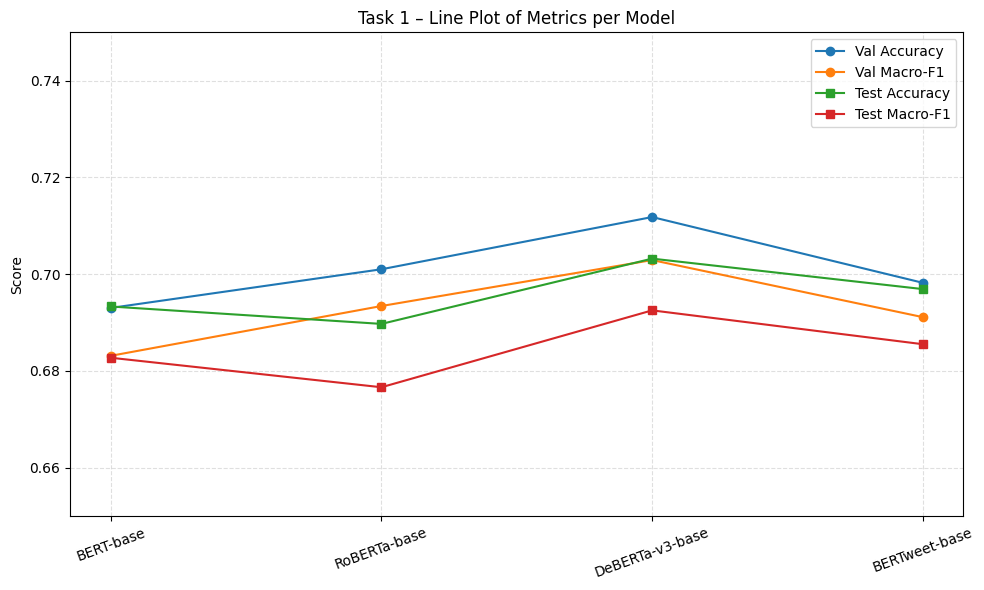

In [ ]:
plt.figure(figsize=(10, 6))

x = np.arange(len(df_task1["Model"]))

# line for each metric
plt.plot(x, df_task1["Val_Accuracy"],  marker="o", label="Val Accuracy")
plt.plot(x, df_task1["Val_MacroF1"],   marker="o", label="Val Macro-F1")
plt.plot(x, df_task1["Test_Accuracy"], marker="s", label="Test Accuracy")
plt.plot(x, df_task1["Test_MacroF1"],  marker="s", label="Test Macro-F1")

plt.xticks(x, df_task1["Model"], rotation=20)
plt.ylabel("Score")
plt.ylim(0.65, 0.75)  # focus on the interesting range
plt.title("Task 1 – Line Plot of Metrics per Model")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


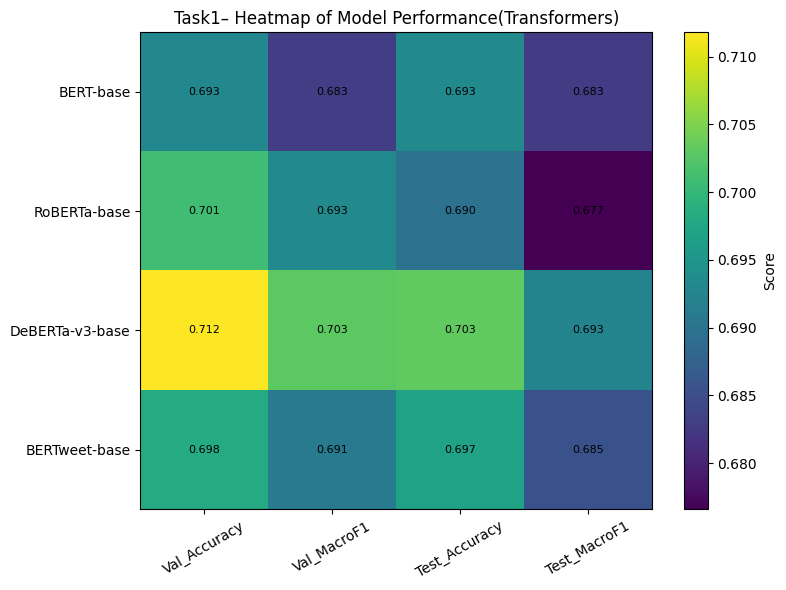

In [ ]:
# we build a matrix of metrics (rows = models, cols = metrics)
metrics = ["Val_Accuracy", "Val_MacroF1", "Test_Accuracy", "Test_MacroF1"]
data_matrix = df_task1[metrics].values  # shape: (n_models, n_metrics)

plt.figure(figsize=(8, 6))

# show matrix as image (heatmap style)
im = plt.imshow(data_matrix, aspect="auto")

# add x/y tick labels
plt.xticks(np.arange(len(metrics)), metrics, rotation=30)
plt.yticks(np.arange(len(df_task1["Model"])), df_task1["Model"])

plt.colorbar(im, label="Score")
plt.title("Task1– Heatmap of Model Performance(Transformers)")

# add numbers inside each cell
for i in range(data_matrix.shape[0]):
    for j in range(data_matrix.shape[1]):
        value = data_matrix[i, j]
        plt.text(
            j, i,
            f"{value:.3f}",
            ha="center",
            va="center",
            color="black",
            fontsize=8,
        )

plt.tight_layout()
plt.show()


# Task 2

## Task 2 without Augmentation

### Build Multi-Hot Target Labels

In [ ]:
# these are the 11 target groups we care about
target_categories = [
    "African", "Asian", "Caucasian", "Women", "Jewish",
    "Homosexual", "Islam", "Other", "Hispanic", "Refugee", "Men"
]

def build_multihot(df):
    """
    Here I turn the nested 'targets_all' list into:
    - flat_targets: unique target names for each tweet
    - one column per target (0/1)
    """
    # flatten the nested lists: [['African','Women'], ...] -> ['African','Women']
    df["flat_targets"] = df["targets_all"].apply(
        lambda lst: list(set([t for row in lst for t in row]))
    )

    # drop the "None" label (means no target)
    df["flat_targets"] = df["flat_targets"].apply(
        lambda row: [t for t in row if t != "None"]
    )

    # create 0/1 columns for each target group
    for tg in target_categories:
        df[tg] = df["flat_targets"].apply(lambda row: 1 if tg in row else 0)

    return df

# apply this to train/val/test splits
df_train = build_multihot(df_train)
df_val   = build_multihot(df_val)
df_test  = build_multihot(df_test)

# just to check that everything looks okay
print("\n=== Sample rows after building multi-hot columns ===")
print(df_train.head(5)[["text", "flat_targets"] + target_categories])



=== Sample rows after building multi-hot columns ===
                                                text  \
0  we cannot continue calling ourselves feminists...   
1                      nawt yall niggers ignoring me   
2  <user> i am bit confused coz chinese ppl can n...   
3  and this is why i end up with nigger trainee d...   
4                  nogs jews and dykes how enriching   

                    flat_targets  African  Asian  Caucasian  Women  Jewish  \
0                             []        0      0          0      0       0   
1                      [African]        1      0          0      0       0   
2                        [Asian]        0      1          0      0       0   
3                      [African]        1      0          0      0       0   
4  [Homosexual, African, Jewish]        1      0          0      0       1   

   Homosexual  Islam  Other  Hispanic  Refugee  Men  
0           0      0      0         0        0    0  
1           0      0      0     

### Tokenize Text + Build Float Labels

In [ ]:

#I just reuse the same list for convenience
target_cols = target_categories

#turn pandas DataFrames into HF Datasets
train_ds = Dataset.from_pandas(df_train.reset_index(drop=True))
val_ds   = Dataset.from_pandas(df_val.reset_index(drop=True))
test_ds  = Dataset.from_pandas(df_test.reset_index(drop=True))

#load DeBERTa tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")

def tokenize_batch(batch):
    """
    Here I:
    - tokenize the tweet text
    - build a multi-label vector as float (0.0 / 1.0) for each example
    """
    # encode the text
    enc = tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

    labels = []
    for i in range(len(batch["text"])):
        # get 0/1 for all target columns
        row_ints = [batch[col][i] for col in target_cols]
        # convert them to float for BCEWithLogitsLoss
        row_floats = [float(v) for v in row_ints]
        labels.append(row_floats)

    enc["labels"] = labels
    return enc

# map tokenization function over all splits
train_tok = train_ds.map(tokenize_batch, batched=True)
val_tok   = val_ds.map(tokenize_batch, batched=True)
test_tok  = test_ds.map(tokenize_batch, batched=True)

# tell HF Trainer which columns are tensors
train_tok.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_tok.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_tok.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/15383 [00:00<?, ? examples/s]

Map:   0%|          | 0/1922 [00:00<?, ? examples/s]

Map:   0%|          | 0/1924 [00:00<?, ? examples/s]

### DeBERTa Model, Metrics, Trainer, Training

In [ ]:

# load DeBERTa for sequence classification
model = AutoModelForSequenceClassification.from_pretrained(
    "microsoft/deberta-v3-base",
    num_labels=len(target_cols)
)

# tell the model that this is actually a multi-label problem
model.config.problem_type = "multi_label_classification"

def compute_metrics(pred):
    """
    Here I compute micro-F1 and macro-F1 for multi-label classification.
    """
    logits, labels = pred
    # turn logits into probabilities
    probs = expit(logits)
    # simple threshold at 0.5
    preds = (probs > 0.5).astype(int)

    # micro-F1 across all labels and all samples
    micro = f1_score(
        labels.reshape(-1),
        preds.reshape(-1),
        average="micro",
        zero_division=0
    )

    # macro-F1 across label dimensions
    macro = f1_score(
        labels,
        preds,
        average="macro",
        zero_division=0
    )

    return {"micro_f1": micro, "macro_f1": macro}

# basic training arguments, nothing fancy
training_args = TrainingArguments(
    output_dir="./task2_deberta_multilabel",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=3,   # I keep 1 epoch just to test quickly
    learning_rate=2e-5,
    logging_steps=200,
    report_to="none"      # I don't want wandb or other loggers
)

# create the Trainer object
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# actually train the model
trainer.train()


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1541762756.py:56: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Step,Training Loss
200,0.379300
400,0.313700
600,0.268900
800,0.245100
1000,0.228700
1200,0.213300
1400,0.216100
1600,0.206600
1800,0.210000
2000,0.206300


TrainOutput(global_step=5769, training_loss=0.1991308724411151, metrics={'train_runtime': 2079.4055, 'train_samples_per_second': 22.193, 'train_steps_per_second': 2.774, 'total_flos': 3035877760099584.0, 'train_loss': 0.1991308724411151, 'epoch': 3.0})

### Evaluate on Validation and Test (micro/macro F1)

In [ ]:

# just to keep names clean
label_names = target_cols   # our 11 categories

def evaluate_split(name, dataset):
    """
    I evaluate one dataset split (val or test)
    and print all metrics in a clean way.
    """
    print(f"\n=== {name} Metrics (Task 2 – DeBERTa, multi-label) ===")

    # this runs the model + compute_metrics (micro/macro)
    results = trainer.evaluate(eval_dataset=dataset)

    # basic metrics coming from compute_metrics
    micro = results.get('eval_micro_f1')
    macro = results.get('eval_macro_f1')

    print(f"micro-F1:   {micro:.4f}")
    print(f"macro-F1:   {macro:.4f}")
    print(f"eval_loss:  {results.get('eval_loss'):.4f}")

    # -------------------------------------------------------
    # Now compute weighted-F1 and per-class F1 manually
    # -------------------------------------------------------

    # get raw predictions from trainer
    raw_pred = trainer.predict(dataset)
    logits = raw_pred.predictions
    labels = raw_pred.label_ids

    # convert logits -> probabilities -> binary predictions
    from scipy.special import expit
    probs = expit(logits)
    preds = (probs > 0.5).astype(int)

    # Weighted F1 (takes class imbalance into account)
    weighted = f1_score(labels, preds, average="weighted", zero_division=0)
    print(f"weighted-F1: {weighted:.4f}")

    # Per-class F1 for each of the 11 target groups
    per_class = f1_score(labels, preds, average=None, zero_division=0)

    print("\n--- Per-Class F1 scores ---")
    for name, score in zip(label_names, per_class):
        print(f"{name:12s} : {score:.4f}")   # nice formatting

    return results


# Run Full Evaluation on Val + Test
evaluate_split("Validation", val_tok)
evaluate_split("Test", test_tok)



=== Validation Metrics (Task 2 – DeBERTa, multi-label) ===


micro-F1:   0.9337
macro-F1:   0.6446
eval_loss:  0.1830
weighted-F1: 0.6745

--- Per-Class F1 scores ---
African      : 0.8266
Asian        : 0.6400
Caucasian    : 0.5574
Women        : 0.6187
Jewish       : 0.9174
Homosexual   : 0.8731
Islam        : 0.8619
Other        : 0.4550
Hispanic     : 0.6250
Refugee      : 0.7157
Men          : 0.0000

=== Test Metrics (Task 2 – DeBERTa, multi-label) ===


micro-F1:   0.9397
macro-F1:   0.6670
eval_loss:  0.1720
weighted-F1: 0.6913

--- Per-Class F1 scores ---
African      : 0.8400
Asian        : 0.7438
Caucasian    : 0.5411
Women        : 0.6357
Jewish       : 0.8928
Homosexual   : 0.8867
Islam        : 0.8772
Other        : 0.4739
Hispanic     : 0.6796
Refugee      : 0.7661
Men          : 0.0000


{'eval_loss': 0.17202304303646088,
 'eval_micro_f1': 0.9396616896616896,
 'eval_macro_f1': 0.6669788306237364,
 'eval_runtime': 17.6995,
 'eval_samples_per_second': 108.704,
 'eval_steps_per_second': 6.836,
 'epoch': 3.0}

##Task 2 with Augmentation

### Oversample minority target groups in df_train

In [ ]:

# I define which target columns I want to oversample
minority_labels = ["Men", "Asian", "Caucasian", "Refugee", "Hispanic", "Other"]

# this is the minimum number of examples I want per class
TARGET_SIZE = 1500  # you can change this number

def oversample_one_label(df, label_col, target_size=TARGET_SIZE):
    """
    Here I oversample one label:
    - I find all rows where this label == 1
    - I repeat them until we reach ~target_size
    """
    # all rows that have this target
    sub = df[df[label_col] == 1]
    n_current = len(sub)

    # if there is no data or already enough, I just return df
    if n_current == 0 or n_current >= target_size:
        return df

    # how many extra copies do we need?
    # I use ceil to go a bit above the target
    reps = int(np.ceil(target_size / n_current)) - 1

    # repeat the minority rows `reps` times and append
    df_aug = pd.concat([df] + [sub] * reps, ignore_index=True)
    return df_aug

# start from original training data
df_train_bal = df_train.copy()

# oversample for each minority label
for lbl in minority_labels:
    df_train_bal = oversample_one_label(df_train_bal, lbl, TARGET_SIZE)
    print(lbl, "→ new size:", df_train_bal[df_train_bal[lbl] == 1].shape[0])

# shuffle the balanced training data (just good practice)
df_train_bal = df_train_bal.sample(frac=1, random_state=42).reset_index(drop=True)

print("\nOriginal train size:", df_train.shape[0])
print("Balanced train size:", df_train_bal.shape[0])


Men → new size: 2460
Asian → new size: 1716
Caucasian → new size: 1677
Refugee → new size: 1523
Hispanic → new size: 1628
Other → new size: 3242

Original train size: 15383
Balanced train size: 18571


### Tokenize Text + Build Float Labels

In [ ]:

#I just reuse the same list for convenience
target_cols = target_categories

#turn pandas DataFrames into HF Datasets
train_ds = Dataset.from_pandas(df_train_bal.reset_index(drop=True))
val_ds   = Dataset.from_pandas(df_val.reset_index(drop=True))
test_ds  = Dataset.from_pandas(df_test.reset_index(drop=True))

#load DeBERTa tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")

def tokenize_batch(batch):
    """
    Here I:
    - tokenize the tweet text
    - build a multi-label vector as float (0.0 / 1.0) for each example
    """
    # encode the text
    enc = tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

    labels = []
    for i in range(len(batch["text"])):
        # get 0/1 for all target columns
        row_ints = [batch[col][i] for col in target_cols]
        # convert them to float for BCEWithLogitsLoss
        row_floats = [float(v) for v in row_ints]
        labels.append(row_floats)

    enc["labels"] = labels
    return enc

# map tokenization function over all splits
train_tok = train_ds.map(tokenize_batch, batched=True)
val_tok   = val_ds.map(tokenize_batch, batched=True)
test_tok  = test_ds.map(tokenize_batch, batched=True)

# tell HF Trainer which columns are tensors
train_tok.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_tok.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_tok.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/18571 [00:00<?, ? examples/s]

Map:   0%|          | 0/1922 [00:00<?, ? examples/s]

Map:   0%|          | 0/1924 [00:00<?, ? examples/s]

### DeBERTa Model, Metrics, Trainer, Training

In [ ]:
# Cell 0: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

print("Google Drive mounted successfully!")


Mounted at /content/drive
Google Drive mounted successfully!


In [ ]:
# load DeBERTa for sequence classification
model = AutoModelForSequenceClassification.from_pretrained(
    "microsoft/deberta-v3-base",
    num_labels=len(target_cols)
)

# tell the model that this is actually a multi-label problem
model.config.problem_type = "multi_label_classification"

def compute_metrics(pred):
    """
    Here I compute micro-F1 and macro-F1 for multi-label classification.
    (I still need this for Trainer, but I won't save the metrics.)
    """
    logits, labels = pred
    probs = expit(logits)
    preds = (probs > 0.5).astype(int)

    micro = f1_score(
        labels.reshape(-1),
        preds.reshape(-1),
        average="micro",
        zero_division=0
    )

    macro = f1_score(
        labels,
        preds,
        average="macro",
        zero_division=0
    )

    return {"micro_f1": micro, "macro_f1": macro}

# training settings
training_args = TrainingArguments(
    output_dir="./task2_deberta_multilabel_checkpoints",  # local checkpoints only
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    learning_rate=2e-5,
    logging_steps=200,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# ---- train the model ----
trainer.train()

# -----------------------------------------
# Save ONLY the trained model to Google Drive
# -----------------------------------------

save_dir = "/content/drive/MyDrive/Task2_DeBERTa_trained"

# make sure the folder exists
os.makedirs(save_dir, exist_ok=True)

# save model weights + config
model.save_pretrained(save_dir)

print("Trained model saved to Google Drive ✅")
print("Folder:", save_dir)


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2878111157.py:53: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Step,Training Loss
200,0.436800
400,0.374700
600,0.335200
800,0.310400
1000,0.299300
1200,0.267200
1400,0.259000
1600,0.249500
1800,0.244900
2000,0.243400


Trained model saved to Google Drive ✅
Folder: /content/drive/MyDrive/Task2_DeBERTa_trained


### Evaluate on Validation and Test (micro/macro F1)

In [ ]:

# just to keep names clean
label_names = target_cols   # our 11 categories

def evaluate_split(name, dataset):
    """
    I evaluate one dataset split (val or test)
    and print all metrics in a clean way.
    """
    print(f"\n=== {name} Metrics (Task 2 – DeBERTa, multi-label) ===")

    # this runs the model + compute_metrics (micro/macro)
    results = trainer.evaluate(eval_dataset=dataset)

    # basic metrics coming from compute_metrics
    micro = results.get('eval_micro_f1')
    macro = results.get('eval_macro_f1')

    print(f"micro-F1:   {micro:.4f}")
    print(f"macro-F1:   {macro:.4f}")
    print(f"eval_loss:  {results.get('eval_loss'):.4f}")

    # -------------------------------------------------------
    # Now compute weighted-F1 and per-class F1 manually
    # -------------------------------------------------------

    # get raw predictions from trainer
    raw_pred = trainer.predict(dataset)
    logits = raw_pred.predictions
    labels = raw_pred.label_ids

    # convert logits -> probabilities -> binary predictions
    from scipy.special import expit
    probs = expit(logits)
    preds = (probs > 0.5).astype(int)

    # Weighted F1 (takes class imbalance into account)
    weighted = f1_score(labels, preds, average="weighted", zero_division=0)
    print(f"weighted-F1: {weighted:.4f}")

    # Per-class F1 for each of the 11 target groups
    per_class = f1_score(labels, preds, average=None, zero_division=0)

    print("\n--- Per-Class F1 scores ---")
    for name, score in zip(label_names, per_class):
        print(f"{name:12s} : {score:.4f}")   # nice formatting

    return results


# ---- Run Full Evaluation on Val + Test ----
evaluate_split("Validation", val_tok)
evaluate_split("Test", test_tok)



=== Validation Metrics (Task 2 – DeBERTa, multi-label) ===


micro-F1:   0.9340
macro-F1:   0.6598
eval_loss:  0.1834
weighted-F1: 0.6799

--- Per-Class F1 scores ---
African      : 0.8298
Asian        : 0.6853
Caucasian    : 0.6013
Women        : 0.6356
Jewish       : 0.9099
Homosexual   : 0.8876
Islam        : 0.8581
Other        : 0.4237
Hispanic     : 0.7023
Refugee      : 0.7018
Men          : 0.0222

=== Test Metrics (Task 2 – DeBERTa, multi-label) ===


micro-F1:   0.9387
macro-F1:   0.6722
eval_loss:  0.1753
weighted-F1: 0.6950

--- Per-Class F1 scores ---
African      : 0.8568
Asian        : 0.7273
Caucasian    : 0.5497
Women        : 0.6209
Jewish       : 0.8918
Homosexual   : 0.8768
Islam        : 0.8800
Other        : 0.4712
Hispanic     : 0.6935
Refugee      : 0.7331
Men          : 0.0936


{'eval_loss': 0.175268292427063,
 'eval_micro_f1': 0.9387166887166887,
 'eval_macro_f1': 0.6722447745284676,
 'eval_runtime': 17.2594,
 'eval_samples_per_second': 111.476,
 'eval_steps_per_second': 7.011,
 'epoch': 3.0}

##

# Task 3

## Build Target Strings from Task 2 Predictions

In [ ]:
#path to the trained Task 2 model in Google Drive
model_path = "/content/drive/MyDrive/Task2_DeBERTa_trained"

#load tokenizer and trained model
#if you already have 'tokenizer' from Task 2, you can reuse it
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")
model = AutoModelForSequenceClassification.from_pretrained(model_path)

#move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

#target groups from Task 2
target_categories = [
    "African", "Asian", "Caucasian", "Women", "Jewish",
    "Homosexual", "Islam", "Other", "Hispanic", "Refugee", "Men"
]

#get all texts from test dataframe
texts = df_test["text"].tolist()

# we will run the model in small batches to avoid OOM
batch_size = 32
all_logits = []

for start in range(0, len(texts), batch_size):
    end = start + batch_size
    batch_texts = texts[start:end]

    # tokenize this small batch
    enc = tokenizer(
        batch_texts,
        truncation=True,
        padding=True,
        max_length=128,
        return_tensors="pt"
    )
    enc = {k: v.to(device) for k, v in enc.items()}

    # forward pass (no gradients)
    with torch.no_grad():
        outputs = model(**enc)
        logits_batch = outputs.logits.cpu().numpy()

    all_logits.append(logits_batch)

#stack all batch logits together: shape [N, num_labels]
logits = np.concatenate(all_logits, axis=0)

#logits -> probs -> 0/1 predictions
probs = expit(logits)
preds = (probs > 0.5).astype(int)

#build Task 3 dataframe based on df_test
df_t3 = df_test.copy().reset_index(drop=True)

# add one predicted column per target
for i, tg in enumerate(target_categories):
    df_t3[f"pred_{tg}"] = preds[:, i]

#collect active targets as list
def get_predicted_targets(row):
    active = []
    for tg in target_categories:
        if row[f"pred_{tg}"] == 1:
            active.append(tg)
    return active

df_t3["pred_targets_list"] = df_t3.apply(get_predicted_targets, axis=1)

#also make a readable string for prompts
def join_targets(targets):
    if not targets:
        return "no specific target group"
    if len(targets) == 1:
        return targets[0]
    return ", ".join(targets[:-1]) + " and " + targets[-1]

df_t3["pred_targets_str"] = df_t3["pred_targets_list"].apply(join_targets)

#quick check
df_t3[["text", "pred_targets_list", "pred_targets_str"]].head()


,text,pred_targets_list,pred_targets_str
0,i dont think im getting my baby them white 9 h...,[],no specific target group
1,laura loomer raped me while screaming at me in...,[Jewish],Jewish
2,<user> what did the old lady do was she a nazi...,[],no specific target group
3,as much as i appreciate a format of open discu...,[Hispanic],Hispanic
4,sex be so good a bitch be slow stroking and cr...,[Women],Women


## Connect to Gemini API

In [ ]:

#get the API key from Colab secrets
GEMINI_API_KEY = userdata.get("Gemini_Key")

if GEMINI_API_KEY is None:
    raise ValueError("Gemini_Key secret is not set for this notebook.")

#configure Gemini client
genai.configure(api_key=GEMINI_API_KEY)

#pick your model
gemini_model = genai.GenerativeModel("models/gemini-2.5-flash")

print("Gemini client is ready ✅")


Gemini client is ready ✅


## Generate Task 3 Explanations Using Gemini

In [ ]:
# Call Gemini ONLY for tweets that have at least one target group
def build_prompt_from_task2(row):
    """
    I build a prompt using:
    - the tweet text
    - the predicted target groups from Task 2
    """
    tweet_text = row["text"]
    targets_str = row["pred_targets_str"]  # e.g. "African and Jewish"

    prompt = f"""
You are a content moderation assistant.

Here is a tweet:
\"\"\"{tweet_text}\"\"\"

Our model (Task 2) predicted that this tweet targets: {targets_str}.

In ONE short English sentence, explain what this tweet contains
and which group it is targeting.
Do NOT repeat any slurs or bad words. Just describe the type of content
(for example: hate speech or offensive language) and name the target group.
"""
    return prompt.strip()


def call_gemini(prompt):
    """Small helper to call Gemini and return plain text."""
    response = gemini_model.generate_content(prompt)
    return response.text.strip()


# default value for ALL tweets (normal / no target)
df_t3["task3_gemini_explanation"] = "no target group – model predicted normal/other"

# select ONLY rows where we have at least one predicted target
mask_has_target = df_t3["pred_targets_list"].apply(len) > 0

# if you want to limit due to quota, you can .head(MAX_CALLS)
MAX_CALLS = 8   # change if you have more quota
subset = df_t3[mask_has_target].head(MAX_CALLS).copy()

print(f"Will call Gemini for {len(subset)} tweets that have target groups.")

# loop only over these rows
for idx, row in subset.iterrows():
    prompt = build_prompt_from_task2(row)

    try:
        explanation = call_gemini(prompt)
    except Exception as e:
        print(f"Stopped at row {idx} because of error:", e)
        explanation = "ERROR: quota limit reached"

    # write the explanation back into the main df_t3
    df_t3.loc[idx, "task3_gemini_explanation"] = explanation

    # small sleep
    time.sleep(0.5)

# check a few rows
df_t3[["text", "pred_targets_str", "task3_gemini_explanation"]].head(10)


Will call Gemini for 8 tweets that have target groups.


,text,pred_targets_str,task3_gemini_explanation
0,i dont think im getting my baby them white 9 h...,no specific target group,no target group – model predicted normal/other
1,laura loomer raped me while screaming at me in...,Jewish,This tweet contains antisemitic hate speech an...
2,<user> what did the old lady do was she a nazi...,no specific target group,no target group – model predicted normal/other
3,as much as i appreciate a format of open discu...,Hispanic,This tweet contains offensive language express...
4,sex be so good a bitch be slow stroking and cr...,Women,This tweet contains derogatory and sexually su...
5,<user> <user> <user> with a room full of white...,no specific target group,no target group – model predicted normal/other
6,i do not blame orlando pie rats for loosing li...,no specific target group,no target group – model predicted normal/other
7,they are going to figure out a way to kike bit...,Jewish,This tweet contains hate speech targeting Jewi...
8,<user> <user> a camel jockey midde east wateri...,Islam,This tweet contains hate speech using derogato...
9,then hoes stole my choreo and still managed to...,Women,This tweet contains offensive language and dis...
